In [360]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import pandas as pd
import numpy as np
from math import sqrt
import statsmodels.api as sm
import statsmodels
import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rcParams['figure.figsize'] = [8, 3]


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from src.time_series_helpers import (to_col_vector,
                                 plot_acf_and_pacf,
                                 PolynomialBasisAndDummyizer)
import seaborn as sns
# Always make it pretty.
# plt.style.use('seaborn')

# We get some interger -> float typecast warning from sklean below,
# this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

# from src.to_supervised import series_to_supervised
# from src.plot import plot_per_column_distibution, plot_correlation_matrix, plot_scatter_matrix

## Loading the dataset

In [153]:
!ls ../data

PRSA_Data_Aotizhongxin_20130301-20170228.csv
PRSA_Data_Changping_20130301-20170228.csv
PRSA_Data_Dingling_20130301-20170228.csv
PRSA_Data_Dongsi_20130301-20170228.csv
PRSA_Data_Guanyuan_20130301-20170228.csv
PRSA_Data_Gucheng_20130301-20170228.csv
PRSA_Data_Huairou_20130301-20170228.csv
PRSA_Data_Nongzhanguan_20130301-20170228.csv
PRSA_Data_Shunyi_20130301-20170228.csv
PRSA_Data_Tiantan_20130301-20170228.csv
PRSA_Data_Wanliu_20130301-20170228.csv
PRSA_Data_Wanshouxigong_20130301-20170228.csv


In [366]:
# path = '../data/all_data.csv'
# df = pd.concat(map(pd.read_csv, glob.glob('../data/*.csv')))
# df.to_csv('all_data.csv')
path = '../data/PRSA_Data_Aotizhongxin_20130301-20170228.csv'
df = pd.read_csv('../data/PRSA_Data_Aotizhongxin_20130301-20170228.csv')

## Exploratory Data Analysis

### About the Data

In [156]:
df.head(5)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [ ]:
df = df[['year', 'PM2.5']]

In [157]:
df.shape

(35064, 18)

In [158]:
df.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,34139.000000,34346.000000,34129.000000,34041.000000,33288.000000,33345.000000,35044.000000,35044.000000,35044.000000,35044.000000,35050.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,82.773611,110.060391,17.375901,59.305833,1262.945145,56.353358,13.584607,1011.846920,3.123062,0.067421,1.708496
std,10122.249256,1.177213,3.448752,8.800218,6.922285,82.135694,95.223005,22.823017,37.116200,1221.436236,57.916327,11.399097,10.404047,13.688896,0.910056,1.204071
min,1.000000,2013.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.285600,2.000000,100.000000,0.214200,-16.800000,985.900000,-35.300000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,22.000000,38.000000,3.000000,30.000000,500.000000,8.000000,3.100000,1003.300000,-8.100000,0.000000,0.900000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,58.000000,87.000000,9.000000,53.000000,900.000000,42.000000,14.500000,1011.400000,3.800000,0.000000,1.400000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,114.000000,155.000000,21.000000,82.000000,1500.000000,82.000000,23.300000,1020.100000,15.600000,0.000000,2.200000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,898.000000,984.000000,341.000000,290.000000,10000.000000,423.000000,40.500000,1042.000000,28.500000,72.500000,11.200000


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34139 non-null  float64
 6   PM10     34346 non-null  float64
 7   SO2      34129 non-null  float64
 8   NO2      34041 non-null  float64
 9   CO       33288 non-null  float64
 10  O3       33345 non-null  float64
 11  TEMP     35044 non-null  float64
 12  PRES     35044 non-null  float64
 13  DEWP     35044 non-null  float64
 14  RAIN     35044 non-null  float64
 15  wd       34983 non-null  object 
 16  WSPM     35050 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


## Data Pre Processing

### Dealing with missing data

In [160]:
#summarising number of missing values in each column
df.isnull().sum()

No            0
year          0
month         0
day           0
hour          0
PM2.5       925
PM10        718
SO2         935
NO2        1023
CO         1776
O3         1719
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           81
WSPM         14
station       0
dtype: int64

In [161]:
# percentage of missing values in each column
round(df.isnull().sum()/len(df.index), 2) * 100

No         0.0
year       0.0
month      0.0
day        0.0
hour       0.0
PM2.5      3.0
PM10       2.0
SO2        3.0
NO2        3.0
CO         5.0
O3         5.0
TEMP       0.0
PRES       0.0
DEWP       0.0
RAIN       0.0
wd         0.0
WSPM       0.0
station    0.0
dtype: float64

In [365]:
df_corr = df[['PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']]
df = df[['PM2.5']]

<AxesSubplot:>

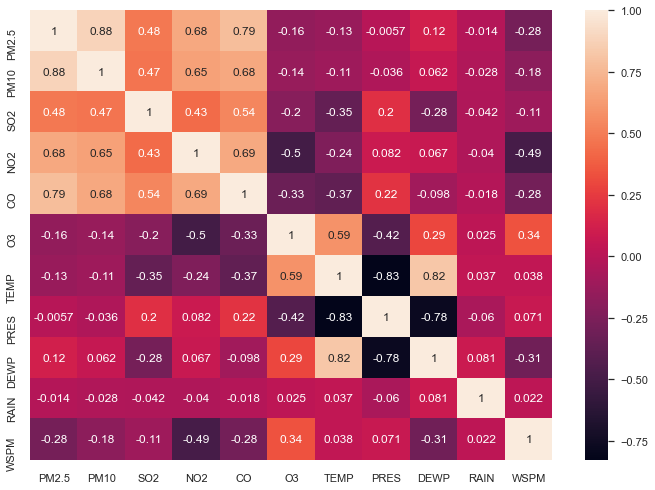

In [364]:
corr_matrix = df_corr.corr()
sns.set(rc={'figure.figsize':(11.7, 8.27)})
sns.heatmap(corr_matrix, annot=True)

<AxesSubplot:>

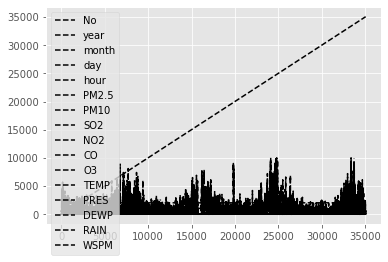

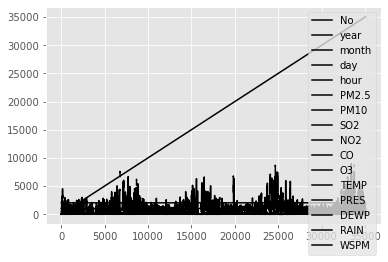

In [162]:
#pd.rolling_mean(df, window = 2)[1:10] # in future versions you want to resample separately
r = df.rolling(window = 10)
#r.agg, r.apply, r.count, r.exclusions, r.max, r.median, r.name, r.quantile, r.kurt, r.cov, r.corr, r.aggregate, r.std, r.skew, r.sum, r.var
df.plot(style = 'k--')
r.mean().plot(style = 'k')

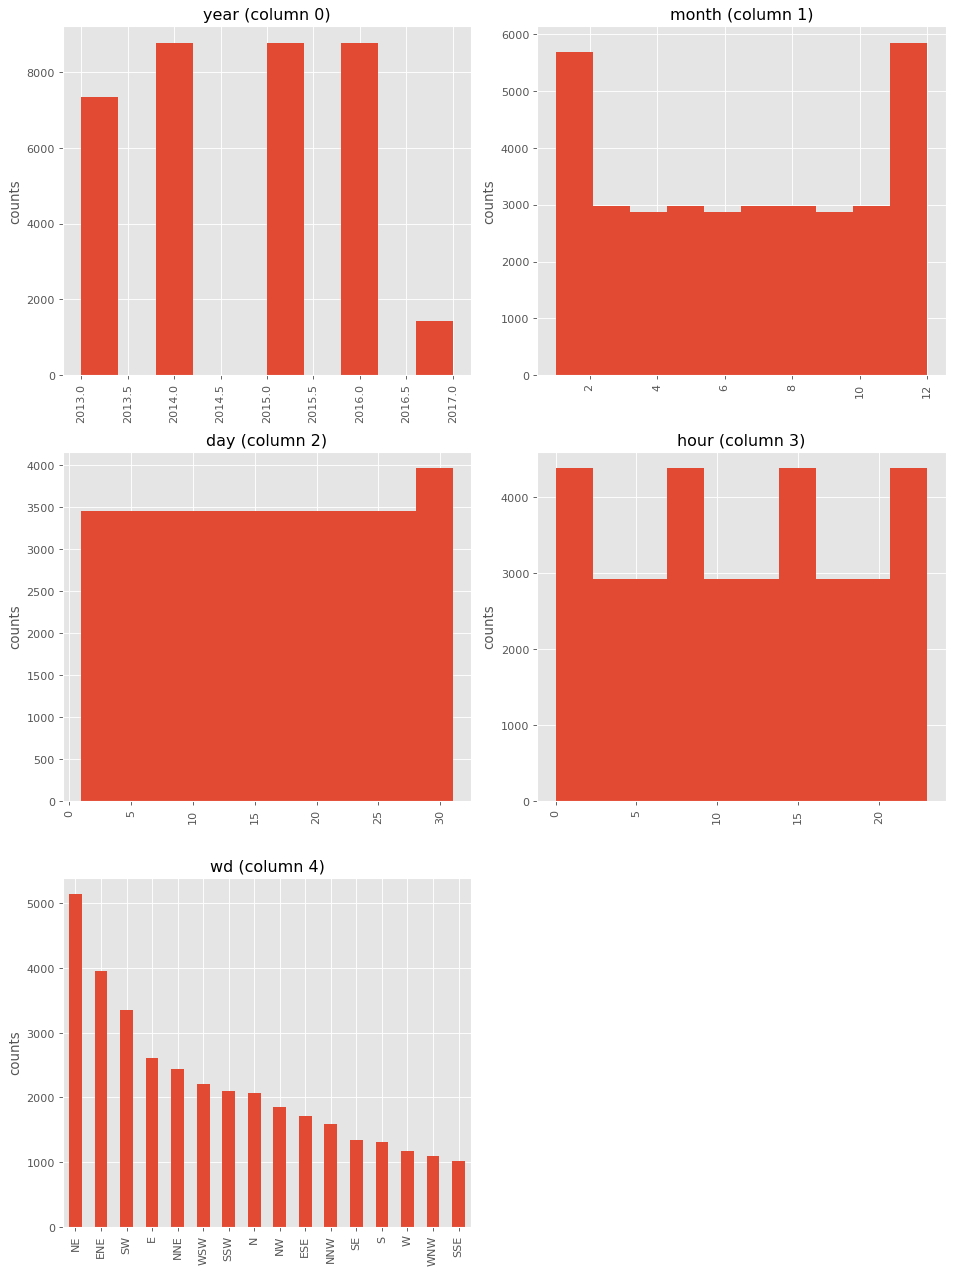

In [163]:
plot_per_column_distibution(df, 10, 2)

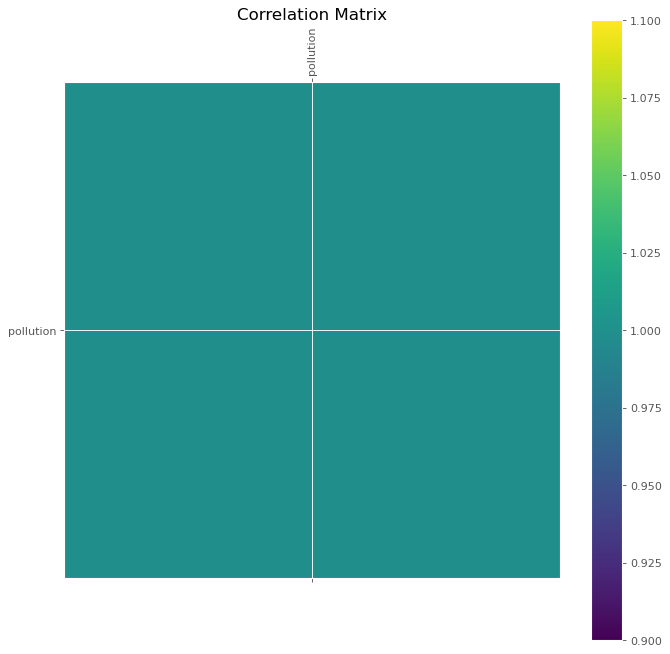

NameError: name 'textSize' is not defined

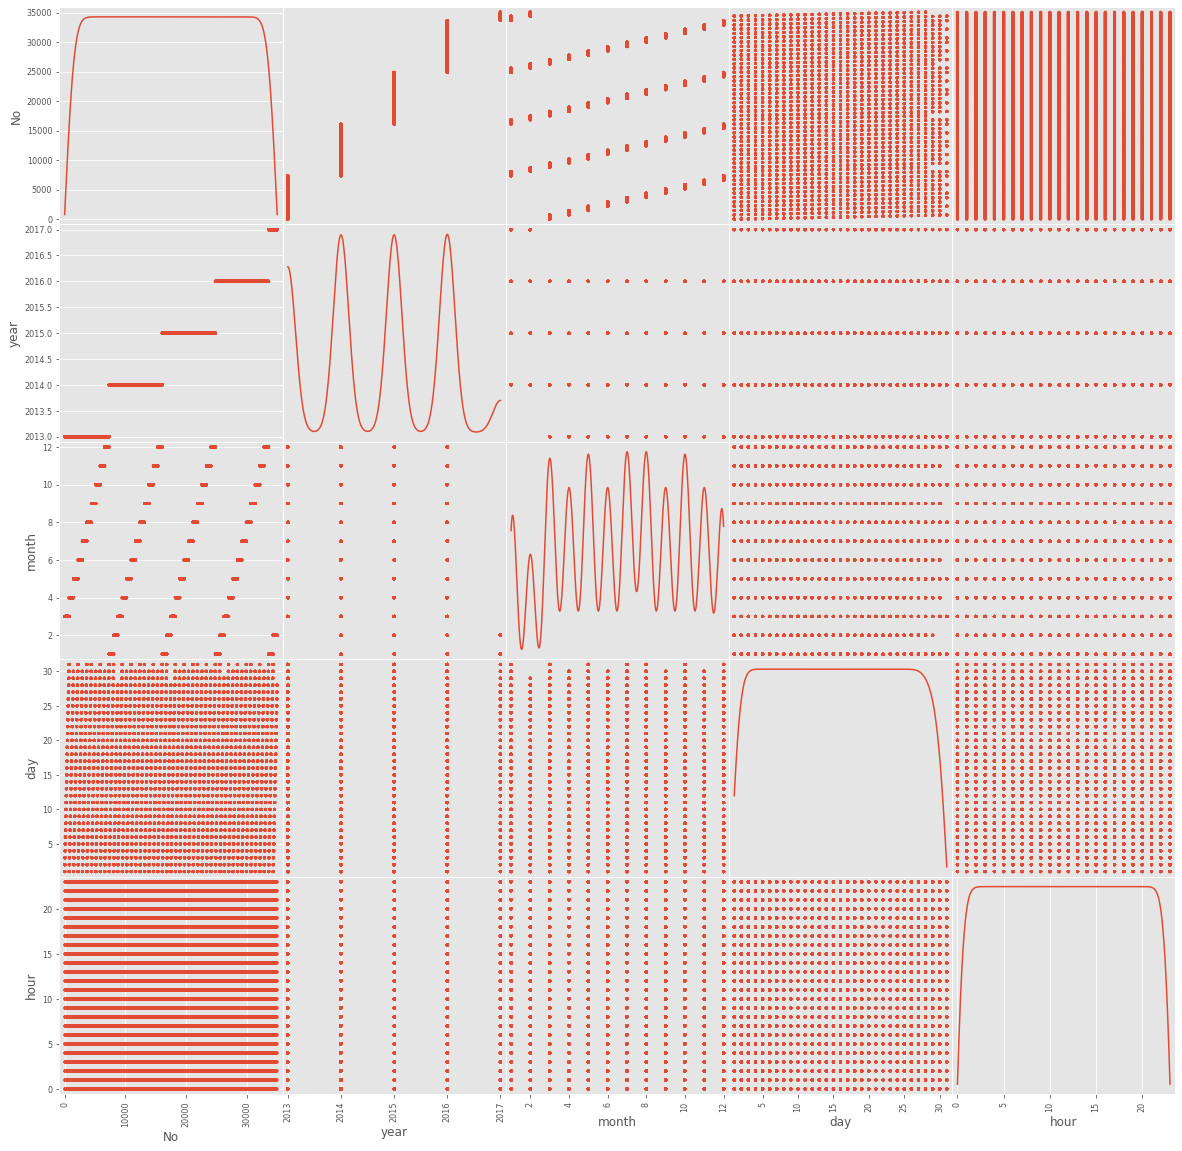

In [167]:
corr_df = pd.read_csv('pollution.csv')
plot_correlation_matrix(corr_df, 10)
plot_scatter_matrix(df, 20, 10)

In [174]:
datetime.strptime()

<function datetime.strptime>

In [218]:

df

,No,year,month,day,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
35060,35061,2017,2,28,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
35061,35062,2017,2,28,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin
35062,35063,2017,2,28,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin


In [368]:
dataset

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
year_month_day_hour,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01 01:00:00,2,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01 02:00:00,3,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01 03:00:00,4,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01 04:00:00,5,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,35060,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
2017-02-28 20:00:00,35061,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
2017-02-28 21:00:00,35062,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin


In [373]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
# dataset.drop(axis=0, inplace=True)
dataset = pd.read_csv(path, parse_dates = [['year', 'month', 'day', 'hour']],index_col=0, date_parser=parse)
# dataset.drop(axis=0, inplace=True)
# manually specify column names
dataset.columns = ['No','PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']

dataset.index = pd.to_datetime(dataset.index)
# mark all NA values with 0
# dataset['pollution'].fillna(0, inplace=True)
# dataset.drop(['wd', 'station'],axis=1, inplace=True)
# drop the first 24 hours
# dataset = dataset[24:]
# summarize first 5 rows

# save to file
# dataset.to_csv('pollution.csv')

In [375]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   PM2.5    34139 non-null  float64
 2   PM10     34346 non-null  float64
 3   SO2      34129 non-null  float64
 4   NO2      34041 non-null  float64
 5   CO       33288 non-null  float64
 6   O3       33345 non-null  float64
 7   TEMP     35044 non-null  float64
 8   PRES     35044 non-null  float64
 9   DEWP     35044 non-null  float64
 10  RAIN     35044 non-null  float64
 11  wd       34983 non-null  object 
 12  WSPM     35050 non-null  float64
 13  station  35064 non-null  object 
dtypes: float64(11), int64(1), object(2)
memory usage: 4.0+ MB


In [144]:
# convert series to supervised learning
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
print(dataset.head(5))
values = dataset.values
values
# integer encode direction

                     pollution  PM2.5  PM10   SO2   NO2      CO    O3  TEMP  \
date                                                                          
2013-03-02 00:00:00         24   14.0  18.0  24.0  43.0  1399.0  25.0  -0.3   
2013-03-02 01:00:00         25   18.0  39.0  25.0  28.0  1300.0  37.0  -0.7   
2013-03-02 02:00:00         26   19.0  29.0  30.0  13.0  1100.0  47.0  -0.8   
2013-03-02 03:00:00         27   15.0  24.0  20.0  12.0  1000.0  46.0  -1.2   
2013-03-02 04:00:00         28   13.0  16.0  21.0  24.0  1200.0  37.0  -1.3   

                       PRES  DEWP  RAIN  WSPM  
date                                           
2013-03-02 00:00:00  1028.9 -18.0   0.0   1.4  
2013-03-02 01:00:00  1029.2 -17.9   0.0   1.0  
2013-03-02 02:00:00  1028.8 -18.0   0.0   1.4  
2013-03-02 03:00:00  1028.6 -17.9   0.0   1.1  
2013-03-02 04:00:00  1028.7 -18.9   0.0   1.1  


array([[ 2.4000e+01,  1.4000e+01,  1.8000e+01, ..., -1.8000e+01,
         0.0000e+00,  1.4000e+00],
       [ 2.5000e+01,  1.8000e+01,  3.9000e+01, ..., -1.7900e+01,
         0.0000e+00,  1.0000e+00],
       [ 2.6000e+01,  1.9000e+01,  2.9000e+01, ..., -1.8000e+01,
         0.0000e+00,  1.4000e+00],
       ...,
       [ 3.5061e+04,  1.8000e+01,  2.8000e+01, ..., -1.2700e+01,
         0.0000e+00,  1.7000e+00],
       [ 3.5062e+04,  1.8000e+01,  2.0000e+01, ..., -1.3200e+01,
         0.0000e+00,  1.8000e+00],
       [ 3.5063e+04,  1.5000e+01,  2.2000e+01, ..., -1.1900e+01,
         0.0000e+00,  1.4000e+00]])

In [145]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(367552, 48)


In [146]:
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.000684   0.012036   0.016048   0.047456   0.259901   0.131212   
4   0.000713   0.016048   0.037111   0.049457   0.168317   0.121212   
5   0.000742   0.017051   0.027081   0.059463   0.067657   0.101010   
6   0.000770   0.013039   0.022066   0.039451   0.061056   0.090909   
7   0.000799   0.011033   0.014042   0.041452   0.142739   0.111111   

   var7(t-3)  var8(t-3)  var9(t-3)  var5(t-2)  ...   var3(t)   var4(t)  \
3   0.023147   0.318699   0.769867   0.168317  ...  0.022066  0.039451   
4   0.034354   0.312195   0.774834   0.067657  ...  0.014042  0.041452   
5   0.043693   0.310569   0.768213   0.061056  ...  0.021063  0.051458   
6   0.042759   0.304065   0.764900   0.142739  ...  0.010030  0.035449   
7   0.034354   0.302439   0.766556   0.052805  ...  0.004012  0.037450   

    var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  var10(t)  var11(t)  \
3  0.061056  0.090909  0.042759  0.304065  0.764900  

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

## ARIMA and Time-series Data


In [210]:
# load the data
logins = read_csv(path, parse_dates = [['year', 'month', 'day']], index_col=0, date_parser=parse)

TypeError: parse() takes 1 positional argument but 3 were given

In [187]:
logins.shape

(35064, 14)

In [188]:
logins.iloc[:, 0]

year_month_day_hour
2013-03-01 00:00:00        1
2013-03-01 01:00:00        2
2013-03-01 02:00:00        3
2013-03-01 03:00:00        4
2013-03-01 04:00:00        5
                       ...  
2017-02-28 19:00:00    35060
2017-02-28 20:00:00    35061
2017-02-28 21:00:00    35062
2017-02-28 22:00:00    35063
2017-02-28 23:00:00    35064
Name: No, Length: 35064, dtype: int64

In [189]:
# The indices should be the timestamps. The values created should be a series of ones so
# that we can count them. You should convert your data frame so that it looks like this 
#(where the left column is your index):
logins_series = pd.Series(1, index=pd.to_datetime(logins.iloc[:, 0]))

In [190]:
logins_daily = logins_series.resample('D').sum()

In [191]:
logins_daily.index

DatetimeIndex(['1970-01-01'], dtype='datetime64[ns]', name='No', freq='D')

In [ ]:
reindex_to_data_frame(df)

<AxesSubplot:xlabel='year_month_day_hour'>

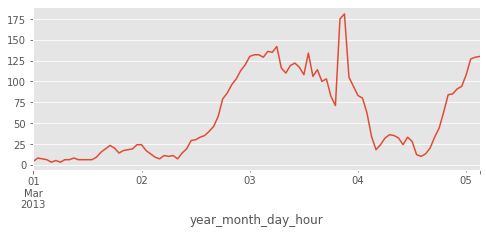

In [198]:
logins.PM10[:100].plot()

<AxesSubplot:xlabel='year_month_day_hour'>

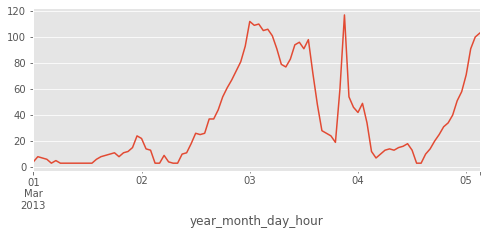

In [199]:
logins['PM2.5'][:100].plot()

In [247]:
dataset


,Date,pollution,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
No,,,,,,,,,,,,,,,
1,2013-03-01,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2,2013-03-01,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
3,2013-03-01,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
4,2013-03-01,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
5,2013-03-01,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35060,2017-02-28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
35061,2017-02-28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
35062,2017-02-28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin


In [249]:
# Pivot the data
dataset = dataset.pivot(index='Date', columns='station', values='PM2.5')

ValueError: Index contains duplicate entries, cannot reshape

<AxesSubplot:xlabel='year_month_day'>

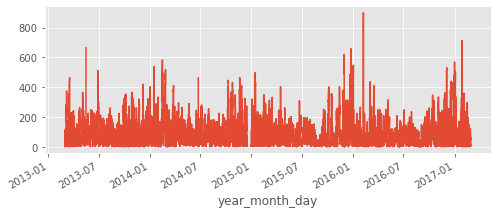

In [266]:
dataset['PM2.5'].plot()

In [261]:
df.index = pd.to_datetime(df.index)

In [262]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [263]:
dataset

,No,pollution,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
year_month_day,,,,,,,,,,,,,,,
2013-03-01,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01,2,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01,3,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01,4,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01,5,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28,35060,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
2017-02-28,35061,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
2017-02-28,35062,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin


<AxesSubplot:xlabel='year_month_day'>

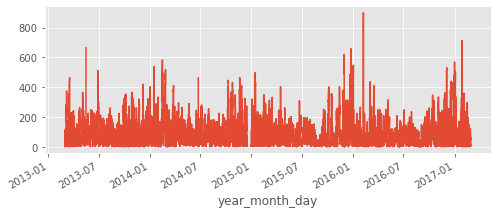

In [265]:
dataset['PM2.5'].plot()

In [268]:
dataset['2013']

,No,pollution,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
year_month_day,,,,,,,,,,,,,,,
2013-03-01,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01,2,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01,3,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01,4,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01,5,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,7340,19,18.0,97.0,8.0,25.0,600.0,41.0,7.5,1007.9,-14.7,0.0,NNW,2.9,Aotizhongxin
2013-12-31,7341,20,18.0,97.0,8.0,25.0,600.0,34.0,7.2,1008.3,-14.3,0.0,WNW,2.0,Aotizhongxin
2013-12-31,7342,21,18.0,102.0,18.0,43.0,700.0,25.0,5.1,1008.6,-14.4,0.0,SW,0.9,Aotizhongxin


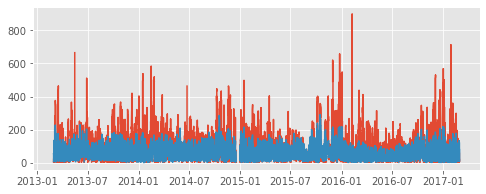

In [275]:
# Get a sense how correlate they are
plt.plot(dataset['2013':'2017'][['PM2.5', 'NO2']])

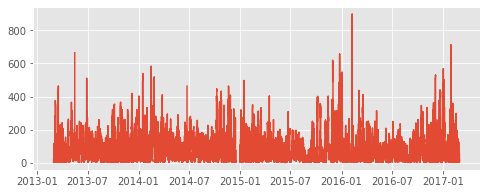

In [276]:
plt.plot(dataset['2013':][['PM2.5']])

In [ ]:
#how helpful are to predict one another or understanding one another?

### How strongly do these measurements correlate contemporaneously? Whatg about with a time lag?

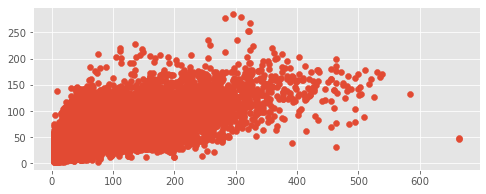

In [282]:
plt.scatter(dataset['2013':'2014'][['PM2.5']], dataset['2013':'2014'][['NO2']])

ValueError: x and y must be the same size

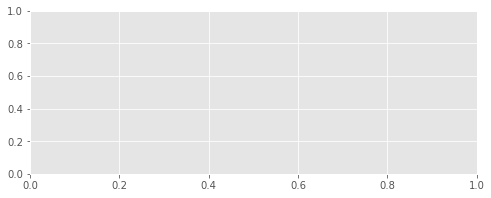

In [283]:
#ofset by a year
plt.scatter(dataset['2013':'2016'][['PM2.5']], dataset['2014':'2017'][['NO2']])

In [292]:
dataset.dropna(axis=0,inplace=True)
dataset.shape

(31815, 15)

In [294]:
# It's good to have different measures, visual and numeric
pearsonr(dataset['2013':'2017']['PM2.5'], dataset['2013':'2017']['O3'])

(-0.1662496826055965, 6.431786553361795e-196)

In [295]:
dataset['2013': '2017'][['PM2.5']].head()

,PM2.5
year_month_day,
2013-03-01,4.0
2013-03-01,8.0
2013-03-01,7.0
2013-03-01,6.0
2013-03-01,3.0


In [297]:
min(dataset.index)

Timestamp('2013-03-01 00:00:00')

In [298]:
max(dataset.index)

Timestamp('2017-02-28 00:00:00')

## Unobserved component model

In [301]:
train = dataset['2016':]

### model parameters


In [300]:
# smooth trend model without seasonal or cyclical components

model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None
}



### fitting a model

In [302]:
pm25_mod = sm.tsa.UnobservedComponents(train['PM2.5'], **model)
pm25_res = pm25_mod.fit()

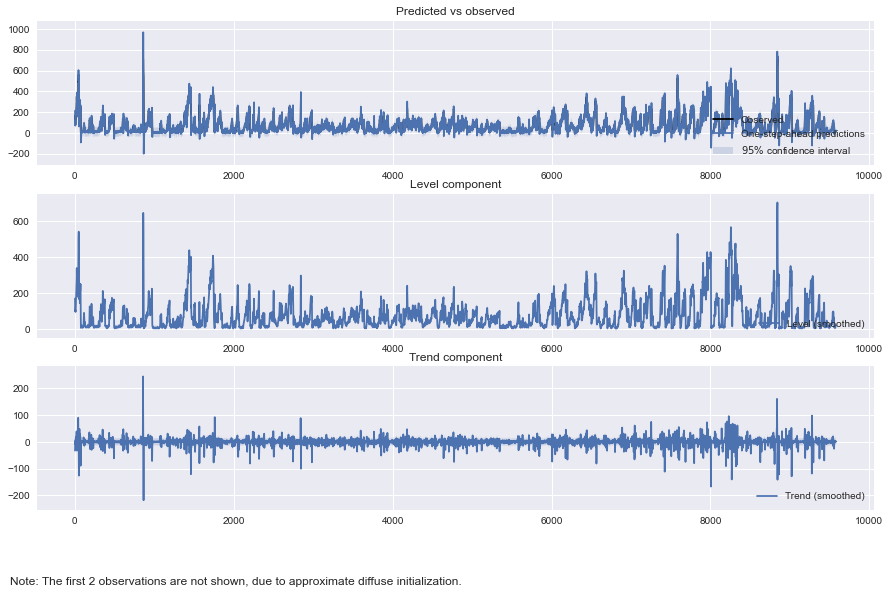

In [311]:
fig = pm25_res.plot_components(legend_loc='lower right', figsize=(15, 9));

### Plotting predictions

In [312]:
# Perform rolling prediction and multistep forecast
num_steps = 20
predict_res = pm25_res.get_prediction(dynamic=train['PM2.5'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

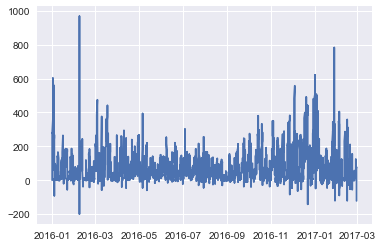

In [313]:
plt.plot(predict)

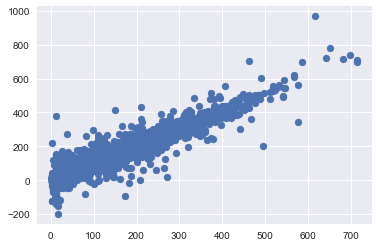

In [315]:
plt.scatter(train['PM2.5'], predict)

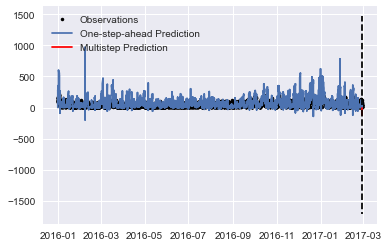

In [319]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['NO2'], 'k.', label='Observations');
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');
#confidence bound rapidly diverdge because of the incorporate error

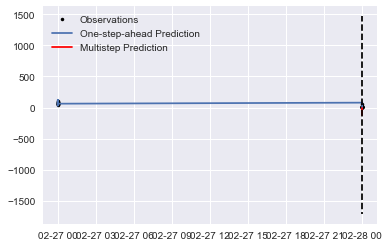

In [322]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:],train['PM2.5'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40: -num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');
#red line shows dynamic prediction, dial line shows confidence bounds
# Forward moving flat line

### Considering adding a seasonal term for 12 periods for the model fit above. Does this imporve the fit of the model?


In [323]:
# we initially rejected the seasonality

In [324]:
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
llmod = sm.tsa.UnobservedComponents(train['PM2.5'], **seasonal_model)
ll_level_res = llmod.fit(method='powell', disp=False)

10.920776843499258

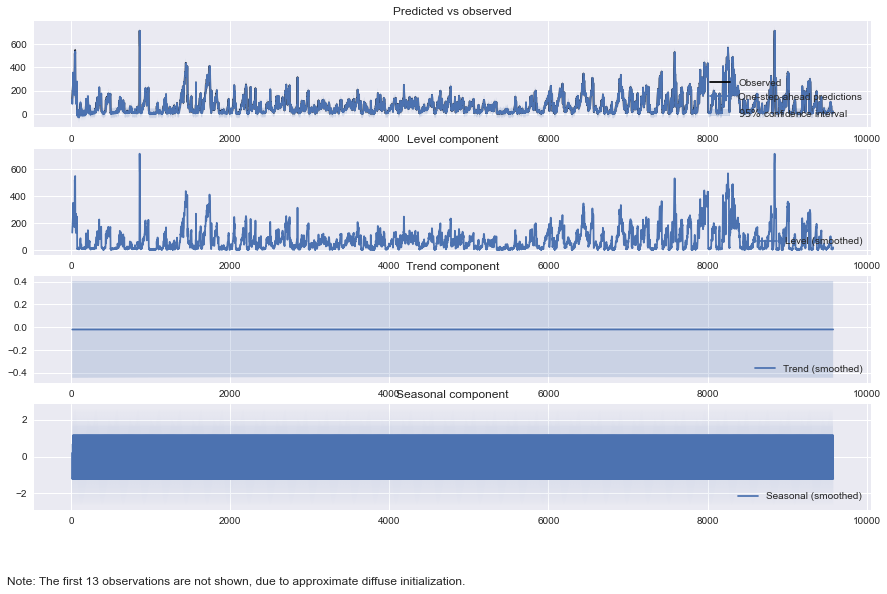

In [326]:
fig = ll_level_res.plot_components(legend_loc='lower right', figsize=(15, 9));
np.mean(np.abs(ll_level_res.predict() - train['PM2.5']))

In [ ]:
# seasonal component is not 0 but is not clearly significant. Doesn't show any pattern of cycle.

### How doest this compare to the original model?


In [327]:
pearsonr(pm25_res.predict(), train['PM2.5'])

(0.9644116627719251, 0.0)

In [333]:
pearsonr(res.predict(), train['PM2.5'])

NameError: name 'res' is not defined

In [328]:
np.mean(np.abs(pm25_res.predict()  - train['PM2.5']))

12.547005745445684

In [332]:
np.mean(np.abs(res.predict() - train['PM2.5']))

NameError: name 'res' is not defined

## Exploring the seasonality more

In [334]:
seasonal_model = {
    'level': 'local level',
    'seasonal': 12
}
llmod = sm.tsa.UnobservedComponents(train['PM2.5'], **seasonal_model)
ll_level_res = llmod.fit(method='powell', disp=False)

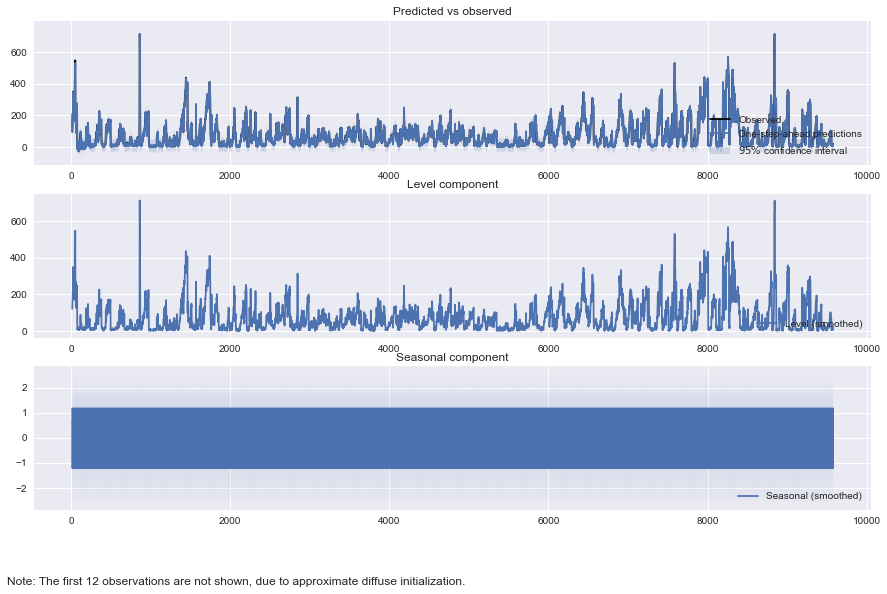

In [335]:
fig = ll_level_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [337]:
np.mean(np.abs(ll_level_res.predict() - train['PM2.5']))

10.909447261394963

In [ ]:
'''
we have 11 coeficients n seasons n-1, at this points we add and subtract this much and that's how we can add seasonal component
it can handle something like incompleate cycle.
'''

<AxesSubplot:xlabel='year_month_day'>

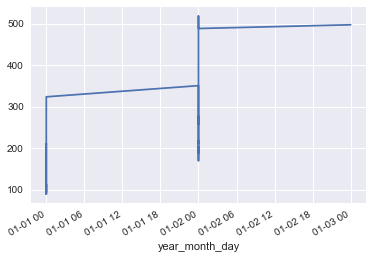

In [338]:
# revisit and see the shape of our data
train[:48]['PM2.5'].plot()

### A common null model for time series is to predict the value at time t-1 for the value at time t. How does such a model compare to the models we fit here?

In [339]:
pearsonr(ll_level_res.predict(), train['PM2.5'])

(0.9690108577915294, 0.0)

In [345]:
'''
what sort of accuracy do I need? Is half of percentage point improvment in correlation meaningful?
Context dependent
Do you really need this? Because you've berely improved your null model. Why do you have it?
'''

"\nwhat sort of accuracy do I need? Is half of percentage point improvment in correlation meaningful?\nContext dependent\nDo you really need this? Because you've berely improved your model. Why do you have it?\n"

In [346]:
pearsonr(train['PM2.5'].iloc[:-1,], train['PM2.5'].iloc[1:, ])

(0.9701483943509523, 0.0)

### What about mean absolute error?


In [ ]:
#Theory about coasasion of the data we are seeing
#Strong domain knowleadge

In [342]:
np.mean(np.abs(ll_level_res.predict()-train['PM2.5']))

10.909447261394963

In [343]:
np.mean(np.abs(train['PM2.5'].iloc[:-1, ].values, train['PM2.5'].iloc[1:, ].values))

76.89623133938825

In [ ]:
'''
This is something worth thinking! Why is that and how we can improve that.
'''

# ARIMA



In [356]:
df1 = dataset['PM2.5'].copy()

In [354]:
df1


year_month_day
2013-03-01     4.0
2013-03-01     8.0
2013-03-01     7.0
2013-03-01     6.0
2013-03-01     3.0
              ... 
2017-02-28    13.0
2017-02-28    12.0
2017-02-28    13.0
2017-02-28    16.0
2017-02-28    21.0
Name: PM2.5, Length: 31815, dtype: float64

In [352]:
log_df1 = np.log(df1['PM2.5'])

KeyError: 'PM2.5'

In [358]:
log_df1[1:10]

NameError: name 'log_df1' is not defined

In [ ]:
log_df1_diff = log_df1 - log_df1.shift()

In [ ]:
# Let's talk about the ARIMA model
# Auto-Regressive Integrated Moving Average
# In this case we're talking about a series with dependence among values (more natural)

# Nothing but a linear regression with a few times
# 1. The number of Auto-Regressive Terms (p)
# 2. The number of Moving Average Terms (q)
# 3. The number of differences taken

In [ ]:
# We don't pull these out of thin air, but rather draw them from the data
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(log_air_passengers_diff.values, nlags = 20)
lag_pacf = pacf(log_air_passengers_diff.values, nlags = 20)

In [ ]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

In [ ]:
# look at where the plot crosses the upper confidence interval for the first time
# for ACF this is 2 and gives us the p value

In [ ]:
plt.subplot(121) 
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

In [ ]:
# look at where the plot crosses the upper confidence interval for the first time
# for PACF this is 2 and gives us the p value

In [359]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# AR model
model = ARIMA(log_air_passengers, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))

In [ ]:
# MA model
model = ARIMA(log_air_passengers, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-log_air_passengers_diff)**2))

In [ ]:
# ARIMA model
model = ARIMA(log_air_passengers, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_air_passengers_diff)**2))

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

In [ ]:
predictions_ARIMA_log = pd.Series(log_air_passengers.ix[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(air_passengers)
plt.plot(predictions_ARIMA)